In [28]:
from notepad import WaterStorage, Heatpump
from pyrecoy.forecasts import Mipf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
import cufflinks
cufflinks.go_offline()
from numpy.polynomial import Polynomial

In [54]:
mipf = Mipf(
    start='2018-11-01', 
    end='2018-11-02', 
    tidy=True, 
    include_nextQ=False,
    folder_path=r"C:\Users\Shahla Huseynova\Recoy\Recoy - Documents\03 - Libraries\12 - Data Management\Forecast Data"
).data
# mipf.columns
price_data = mipf[['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos']]
price_data

DAM    POS    NEG  ForeNeg  ForePos
datetime                                                        
2018-11-01 00:00:00+01:00  44.90  46.39  46.39    80.19    48.13
2018-11-01 00:01:00+01:00  44.90  46.39  46.39    61.21    28.76
2018-11-01 00:02:00+01:00  44.90  46.39  46.39    37.47    21.35
2018-11-01 00:03:00+01:00  44.90  46.39  46.39    65.78    50.15
2018-11-01 00:04:00+01:00  44.90  46.39  46.39    58.43    37.43
...                          ...    ...    ...      ...      ...
2018-11-02 23:55:00+01:00  48.42  37.39  37.39    38.05    38.80
2018-11-02 23:56:00+01:00  48.42  37.39  37.39    41.11    36.20
2018-11-02 23:57:00+01:00  48.42  37.39  37.39    38.51    37.26
2018-11-02 23:58:00+01:00  48.42  37.39  37.39    36.36    33.64
2018-11-02 23:59:00+01:00  48.42  37.39  37.39    34.21    35.14

[2880 rows x 5 columns]

In [31]:
data = pd.read_excel('Demand_Data_Smurfit_Preprocessed.xlsx', sheet_name='nov2018', index_col=0)
start, end = '2018-11-01 00:00:00', '2018-11-01 12:00:00'
df = data[start:end]
df = df.resample('15T', origin=start).mean()
df=df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis=1)
df[:10]

Tsource (VDG)  Tsink (VDG)   MW (VDG)  Tsource (NDG)  \
2018-11-01 00:00:00      64.964783   142.003109   0.000000      19.897433   
2018-11-01 00:15:00      54.578777   138.960493   0.000000      17.950905   
2018-11-01 00:30:00      65.166672   139.885329   0.000000      33.500757   
2018-11-01 00:45:00      65.358078   139.731901   0.000000      42.203876   
2018-11-01 01:00:00      64.947536   139.577871   0.000000      18.702675   
2018-11-01 01:15:00      65.073433   139.423357   0.000000      19.903652   
2018-11-01 01:30:00      47.711559   140.328730   0.000000      19.574467   
2018-11-01 01:45:00      29.525829   140.298902   0.000000      17.065464   
2018-11-01 02:00:00      65.715569   139.991650  10.139587      49.339708   
2018-11-01 02:15:00      65.929909   148.342325  19.585104      61.721718   

                     Tsink (NDG)  MW (NDG)  
2018-11-01 00:00:00   147.731814  0.000000  
2018-11-01 00:15:00   148.138964  0.000000  
2018-11-01 00:30:00   147.585426  0.000000  
2018-11-01 00:45:00   147.547612  0.000000  
2018-11-01 01:00:00   148.260335  0.000000  
2018-11-01 01:15:00   149.186865  0.000000  
2018-11-01 01:30:00   147.800016  0.000000  
2018-11-01 01:45:00   147.906886  0.000000  
2018-11-01 02:00:00   149.603741  3.333301  
2018-11-01 02:15:00   155.887905  6.455359

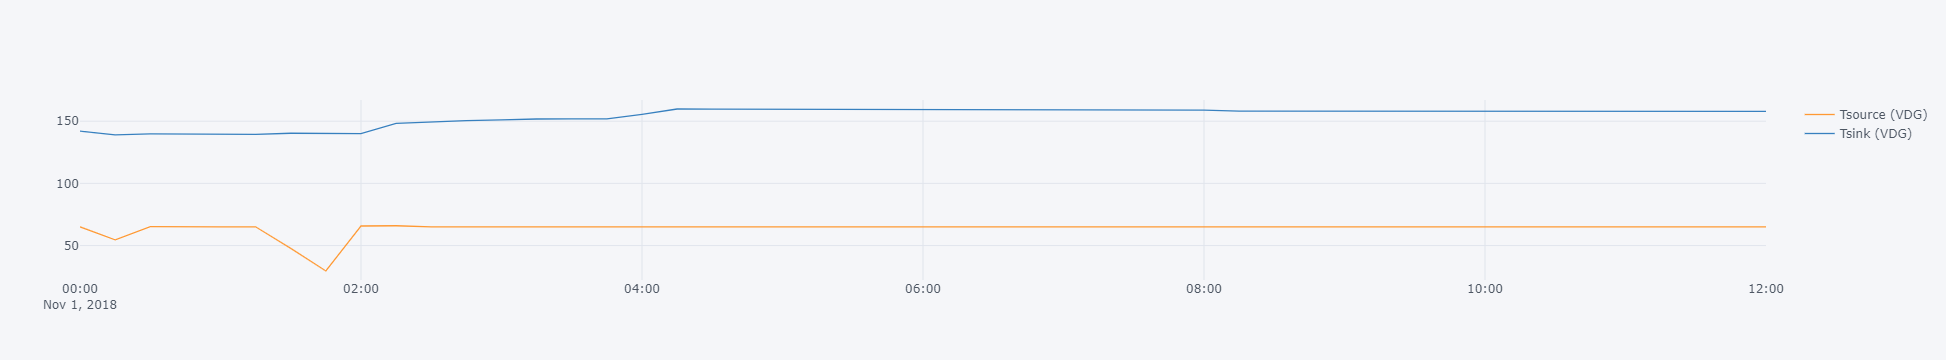

In [32]:
df[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

In [33]:
waterstorage = WaterStorage(
    name='MyStorage',
    max_power=10,
    min_power=-10,
    roundtrip_eff=0.90,
    capacity_per_volume = 50 * 1e-3,
    volume = 1000,
    lifetime = 25,
    temperature = 368, #K
    min_storagelevel = 5,
    # max_storagelevel = 50
    
)
waterstorage.set_freq('15T')
waterstorage.set_storagelevel(15)
waterstorage.storagelevel

15

In [34]:
Tsink = 140  #Celcius
Tsource = 60
Tref = 0
hp_capacity = 31 #MW
process_demand_MW = 25 #MW
Cp = 4190  #J/kgK
MW_to_J_per_s = 1000_000
hp_capacity *= MW_to_J_per_s
process_demand_MW *= MW_to_J_per_s
efficiency = 0.9
Tstorage = 95

In [35]:
waterstorage.max_storage_capacity

50.0

In [36]:
def hp_mass_flow (hp_capacity, Tsink, Tref, Cp):
    return hp_capacity /(Cp*(Tsink - Tref)) 

def process_mass_flow (process_demand_MW, Tsink, Tref, Cp):
    return process_demand_MW /(Cp*(Tsink - Tref)) 

def cop_curve(Tsink, Tsource):
    c0 = Tsink / (Tsink - Tsource)  
    return Polynomial([c0])

charge_mass_flow = hp_mass_flow (hp_capacity, Tsink, Tref, Cp) - process_mass_flow (process_demand_MW, Tsink, Tref, Cp)

def charged_heat (charge_mass_flow, Cp, Tsink, Tref):
    return (charge_mass_flow * Cp * (Tsink - Tref)) / MW_to_J_per_s

discharged_heat = charged_heat(charge_mass_flow, Cp, Tsink, Tref)  #MW

def discharge_mass_flow (discharged_heat, Cp, Tstorage, Tref):
    return discharged_heat * MW_to_J_per_s /(Cp*(Tstorage - Tref))

def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
    return ((Tstorage * discharge_mass_flow + Tsource * process_mass_flow)
                    / (discharge_mass_flow + process_mass_flow))


In [37]:
# heatpump = Heatpump("heatpump1", 50, cop_curve, 10)
# heatpump.set_heat_output(50, Tsource=333, Tsink=413)
cop_curve(140, 60)

heatpump = Heatpump(
    name='Heatpump',
    max_th_power=40,
    min_th_power=5,
    cop_curve=cop_curve
)

heatpump.__dict__



{'name': 'Heatpump',
 'max_th_power': 40,
 'min_th_power': 5,
 'cop_curve': <function __main__.cop_curve(Tsink, Tsource)>}

In [38]:
heatpump.get_cop(50, Tsource=333, Tsink=413)

5.1625

In [39]:
# # if price_data <  price_data['POS']:
# if price_data['ForePos'].empty< 50:
#     hp_load = heatpump.max_th_power
#     energy_to_storage = hp_load - process_demand_MW
#     waterstorage.charge(energy_to_storage)
#     new_cl = waterstorage.storagelevel
#     # def charged_heat (charge_mass_flow, Cp, Tsink, Tref):
#     #     return (charge_mass_flow * Cp * (Tsink - Tref)) / MW_to_J_per_s
# if price_data['ForeNeg'].empty > 100:
#     energy_from_storage = discharged_heat
#     waterstorage.discharge(energy_from_storage)
#     new_cl = waterstorage.storagelevel
#     discharged_heat = charged_heat(charge_mass_flow, Cp, Tsink, Tref)
#     def discharge_mass_flow (discharged_heat, Cp, Tstorage, Tref):
#         return discharged_heat * MW_to_J_per_s /(Cp*(Tstorage - Tref))
#     def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
#         return ((Tstorage * discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + Tsource * process_mass_flow(process_demand_MW, Tsink, Tref, Cp))
#                 / (discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + process_mass_flow(process_demand_MW, Tsink, Tref, Cp)))
#     new_COP = cop_curve (Tsink, Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow))
#     hp_load = heatpump.set_heat_output(process_demand_MW, Tsink, Tsource) #bu da hemcinin set load assetin funksiyasidir, 
#     #heatpump da overwrite edilib. men evezinde yazdim ki set_heat_output
#     #sen gor hansi funksiya sene lazimdir.
# # iki dene funksiyadan cixardim cunki eliye bilmedim onu indi bir funksiya eledim, foreNeg ve ForePosu da elave eledim, indi charged heat ve discharged heati de o logice elave elemeliyem ki eyni vaxtda charge discharge elemesin ondan sonra tsource ve new copni hesablayiram. 

In [40]:
def test_heatpump_and_waterstorage_system(Tsink, Tsource, process_demand_MW, e_price):
    """
    1. Follow a certain logic based on given price:
        - If price is low --> Heatpump at full power, and charge the heatbuffer
        - If price is high --> Discharge the heat buffer, and increase Tsource, which will increase COP
    2. Above logic should adhere to a couple of constraints:
        - Storage levels
        - Capacity of the heat pump 
        - Process demand
        - ....
    3. This function should contain: 
        - Heat pump 
        - Water storage
        - Interactions / logic between them
    4. Output of the function:
        - Power of the heatpump (MWe)
        - "New" water storage level
        - (optional) Thermal output of the heatpump
        - (optional) In/outflow from the storage
    """
    
    if e_price < 50:
        hp_load = heatpump.max_th_power
        energy_to_storage = hp_load - process_demand_MW
        waterstorage.charge(energy_to_storage)
        new_cl = waterstorage.storagelevel
    if e_price > 100:
        energy_from_storage = discharged_heat
        waterstorage.discharge(energy_from_storage)
        new_cl = waterstorage.storagelevel
        
        def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
            return ((Tstorage * discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + Tsource * process_mass_flow(process_demand_MW, Tsink, Tref, Cp))
                    / (discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + process_mass_flow(process_demand_MW, Tsink, Tref, Cp)))
        new_COP = cop_curve (Tsink, Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow))
        hp_load = heatpump.set_heat_output(process_demand_MW, Tsink, Tsource) #bu da hemcinin set load assetin funksiyasidir, 
        #heatpump da overwrite edilib. men evezinde yazdim ki set_heat_output
        #sen gor hansi funksiya sene lazimdir.

    return hp_load, new_cl

In [41]:
# waterstorage.get_soc (30, 50)

In [42]:
for i in df.index:
    df.loc[i, 'hp_mass'] = hp_mass_flow(hp_capacity, df.loc[i, 'Tsink (VDG)']+273, Tref + 273, Cp)
    df.loc[i, 'process_mass'] = process_mass_flow(process_demand_MW, df.loc[i, 'Tsink (VDG)']+273,Tref + 273, Cp)
    df.loc[i, 'COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
    df.loc[i, 'charge_mass'] = df.loc[i, 'hp_mass'] - df.loc[i, 'process_mass']
    df.loc[i, 'charged_heat'] = charged_heat(df.loc[i, 'charge_mass'], Cp, df.loc[i, 'Tsink (VDG)']+273, Tref + 273)
    df.loc[i, 'discharged_heat'] = charged_heat(df.loc[i, 'charge_mass'], Cp, df.loc[i, 'Tsink (VDG)']+273, Tref + 273)
    df.loc[i, 'discharge_mass'] = discharge_mass_flow(df.loc[i, 'discharged_heat'], Cp, Tstorage+273, Tref+273)
    df.loc[i, 'Tsource_new'] = Tsource_calculation(Tstorage + 273, df.loc[i, 'discharge_mass'], df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'process_mass'])
    df.loc[i, 'new_COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource_new'])
    
df.head(10)
# Tsource_new should be in the nested function but now it is calculated separately, need to be checked again
# discharge_mass were checked manually,there is  very slight change in the last decimals that's why seems constant here, but it calculates correctly.

Tsource (VDG)  Tsink (VDG)   MW (VDG)  Tsource (NDG)  \
2018-11-01 00:00:00      64.964783   142.003109   0.000000      19.897433   
2018-11-01 00:15:00      54.578777   138.960493   0.000000      17.950905   
2018-11-01 00:30:00      65.166672   139.885329   0.000000      33.500757   
2018-11-01 00:45:00      65.358078   139.731901   0.000000      42.203876   
2018-11-01 01:00:00      64.947536   139.577871   0.000000      18.702675   
2018-11-01 01:15:00      65.073433   139.423357   0.000000      19.903652   
2018-11-01 01:30:00      47.711559   140.328730   0.000000      19.574467   
2018-11-01 01:45:00      29.525829   140.298902   0.000000      17.065464   
2018-11-01 02:00:00      65.715569   139.991650  10.139587      49.339708   
2018-11-01 02:15:00      65.929909   148.342325  19.585104      61.721718   

                     Tsink (NDG)  MW (NDG)    hp_mass  process_mass  \
2018-11-01 00:00:00   147.731814  0.000000  52.101451     42.017299   
2018-11-01 00:15:00   148.138964  0.000000  53.242241     42.937291   
2018-11-01 00:30:00   147.585426  0.000000  52.890236     42.653416   
2018-11-01 00:45:00   147.547612  0.000000  52.948310     42.700250   
2018-11-01 01:00:00   148.260335  0.000000  53.006741     42.747372   
2018-11-01 01:15:00   149.186865  0.000000  53.065485     42.794746   
2018-11-01 01:30:00   147.800016  0.000000  52.723117     42.518642   
2018-11-01 01:45:00   147.906886  0.000000  52.734326     42.527682   
2018-11-01 02:00:00   149.603741  3.333301  52.850067     42.621021   
2018-11-01 02:15:00   155.887905  6.455359  49.874963     40.221745   

                                      COP  charge_mass  charged_heat  \
2018-11-01 00:00:00   (5.386969459992516)    10.084152           6.0   
2018-11-01 00:15:00   (4.882106135030027)    10.304950           6.0   
2018-11-01 00:30:00  (5.5258665771869335)    10.236820           6.0   
2018-11-01 00:45:00   (5.549424302045392)    10.248060           6.0   
2018-11-01 01:00:00   (5.528286493353138)    10.259369           6.0   
2018-11-01 01:15:00   (5.547058190973266)    10.270739           6.0   
2018-11-01 01:30:00   (4.462765657815752)    10.204474           6.0   
2018-11-01 01:45:00   (3.731041234226957)    10.206644           6.0   
2018-11-01 02:00:00   (5.560223997670469)    10.229045           6.0   
2018-11-01 02:15:00   (5.112607341877656)     9.653219           6.0   

                     discharged_heat  discharge_mass  Tsource_new  \
2018-11-01 00:00:00              6.0       15.073483   345.894878   
2018-11-01 00:15:00              6.0       15.073483   338.081803   
2018-11-01 00:30:00              6.0       15.073483   345.956665   
2018-11-01 00:45:00              6.0       15.073483   346.091818   
2018-11-01 01:00:00              6.0       15.073483   345.781999   
2018-11-01 01:15:00              6.0       15.073483   345.868688   
2018-11-01 01:30:00              6.0       15.073483   333.088278   
2018-11-01 01:45:00              6.0       15.073483   319.659577   
2018-11-01 02:00:00              6.0       15.073483   346.366529   
2018-11-01 02:15:00              6.0       15.073483   346.854418   

                                  new_COP  
2018-11-01 00:00:00   (6.005118422067262)  
2018-11-01 00:15:00   (5.576174793886459)  
2018-11-01 00:30:00  (6.1690359297000565)  
2018-11-01 00:45:00  (6.1934481513445885)  
2018-11-01 01:00:00   (6.176697097419298)  
2018-11-01 01:15:00   (6.196760671334125)  
2018-11-01 01:30:00   (5.151126598798878)  
2018-11-01 01:45:00  (4.4137321606230016)  
2018-11-01 02:00:00   (6.198737740428015)  
2018-11-01 02:15:00  (5.6565198313793505)

In [43]:
for i in df.index:
    # df.loc[i, 'MWe'] = test_heatpump_and_waterstorage_system(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'MW (VDG)'], 130)[0][0]
    df.loc[i, 'new_cl'] = test_heatpump_and_waterstorage_system(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'MW (VDG)'], 30)[1]


In [44]:
df[:10]

Tsource (VDG)  Tsink (VDG)   MW (VDG)  Tsource (NDG)  \
2018-11-01 00:00:00      64.964783   142.003109   0.000000      19.897433   
2018-11-01 00:15:00      54.578777   138.960493   0.000000      17.950905   
2018-11-01 00:30:00      65.166672   139.885329   0.000000      33.500757   
2018-11-01 00:45:00      65.358078   139.731901   0.000000      42.203876   
2018-11-01 01:00:00      64.947536   139.577871   0.000000      18.702675   
2018-11-01 01:15:00      65.073433   139.423357   0.000000      19.903652   
2018-11-01 01:30:00      47.711559   140.328730   0.000000      19.574467   
2018-11-01 01:45:00      29.525829   140.298902   0.000000      17.065464   
2018-11-01 02:00:00      65.715569   139.991650  10.139587      49.339708   
2018-11-01 02:15:00      65.929909   148.342325  19.585104      61.721718   

                     Tsink (NDG)  MW (NDG)    hp_mass  process_mass  \
2018-11-01 00:00:00   147.731814  0.000000  52.101451     42.017299   
2018-11-01 00:15:00   148.138964  0.000000  53.242241     42.937291   
2018-11-01 00:30:00   147.585426  0.000000  52.890236     42.653416   
2018-11-01 00:45:00   147.547612  0.000000  52.948310     42.700250   
2018-11-01 01:00:00   148.260335  0.000000  53.006741     42.747372   
2018-11-01 01:15:00   149.186865  0.000000  53.065485     42.794746   
2018-11-01 01:30:00   147.800016  0.000000  52.723117     42.518642   
2018-11-01 01:45:00   147.906886  0.000000  52.734326     42.527682   
2018-11-01 02:00:00   149.603741  3.333301  52.850067     42.621021   
2018-11-01 02:15:00   155.887905  6.455359  49.874963     40.221745   

                                      COP  charge_mass  charged_heat  \
2018-11-01 00:00:00   (5.386969459992516)    10.084152           6.0   
2018-11-01 00:15:00   (4.882106135030027)    10.304950           6.0   
2018-11-01 00:30:00  (5.5258665771869335)    10.236820           6.0   
2018-11-01 00:45:00   (5.549424302045392)    10.248060           6.0   
2018-11-01 01:00:00   (5.528286493353138)    10.259369           6.0   
2018-11-01 01:15:00   (5.547058190973266)    10.270739           6.0   
2018-11-01 01:30:00   (4.462765657815752)    10.204474           6.0   
2018-11-01 01:45:00   (3.731041234226957)    10.206644           6.0   
2018-11-01 02:00:00   (5.560223997670469)    10.229045           6.0   
2018-11-01 02:15:00   (5.112607341877656)     9.653219           6.0   

                     discharged_heat  discharge_mass  Tsource_new  \
2018-11-01 00:00:00              6.0       15.073483   345.894878   
2018-11-01 00:15:00              6.0       15.073483   338.081803   
2018-11-01 00:30:00              6.0       15.073483   345.956665   
2018-11-01 00:45:00              6.0       15.073483   346.091818   
2018-11-01 01:00:00              6.0       15.073483   345.781999   
2018-11-01 01:15:00              6.0       15.073483   345.868688   
2018-11-01 01:30:00              6.0       15.073483   333.088278   
2018-11-01 01:45:00              6.0       15.073483   319.659577   
2018-11-01 02:00:00              6.0       15.073483   346.366529   
2018-11-01 02:15:00              6.0       15.073483   346.854418   

                                  new_COP  new_cl  
2018-11-01 00:00:00   (6.005118422067262)    25.0  
2018-11-01 00:15:00   (5.576174793886459)    35.0  
2018-11-01 00:30:00  (6.1690359297000565)    45.0  
2018-11-01 00:45:00  (6.1934481513445885)    47.5  
2018-11-01 01:00:00   (6.176697097419298)    47.5  
2018-11-01 01:15:00   (6.196760671334125)    47.5  
2018-11-01 01:30:00   (5.151126598798878)    47.5  
2018-11-01 01:45:00  (4.4137321606230016)    47.5  
2018-11-01 02:00:00   (6.198737740428015)    47.5  
2018-11-01 02:15:00  (5.6565198313793505)    47.5

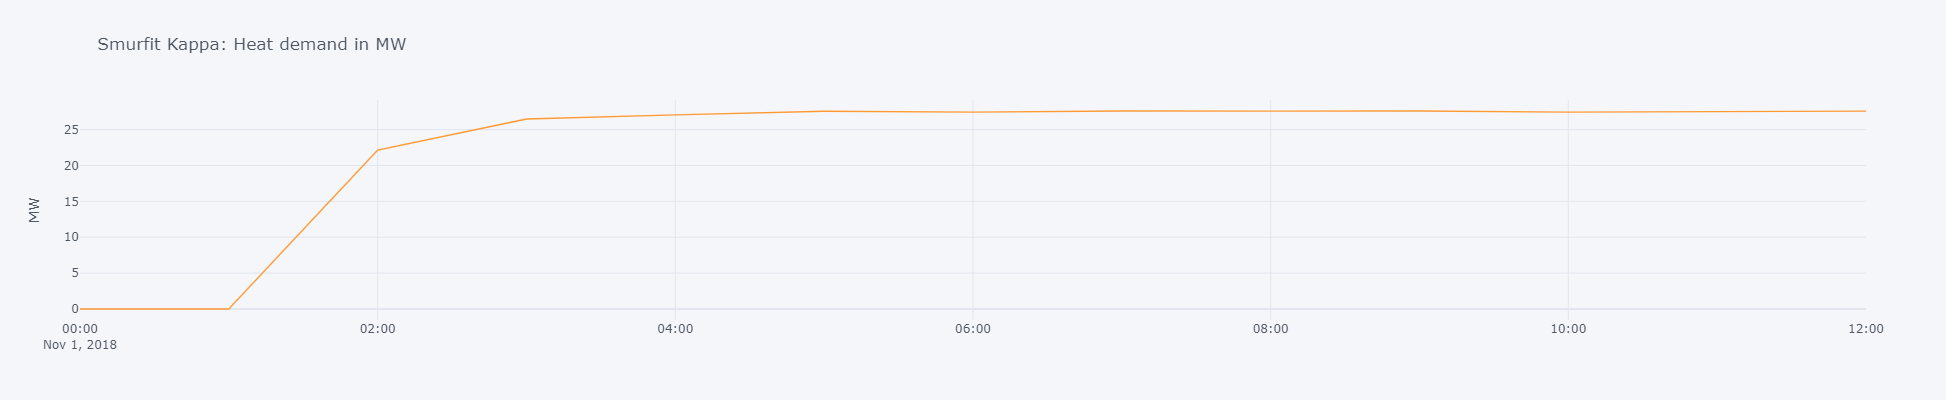

In [45]:
data['Total demand'] = data['MW (VDG)'] + data['MW (NDG)']
data = data[start:end]
fig_demands_nov2018 = data['Total demand'].resample('1H').mean().iplot(
    title='Smurfit Kappa: Heat demand in MW', 
    yTitle='MW', 
    asFigure=True,
    dimensions=(800, 400)
)
fig_demands_nov2018

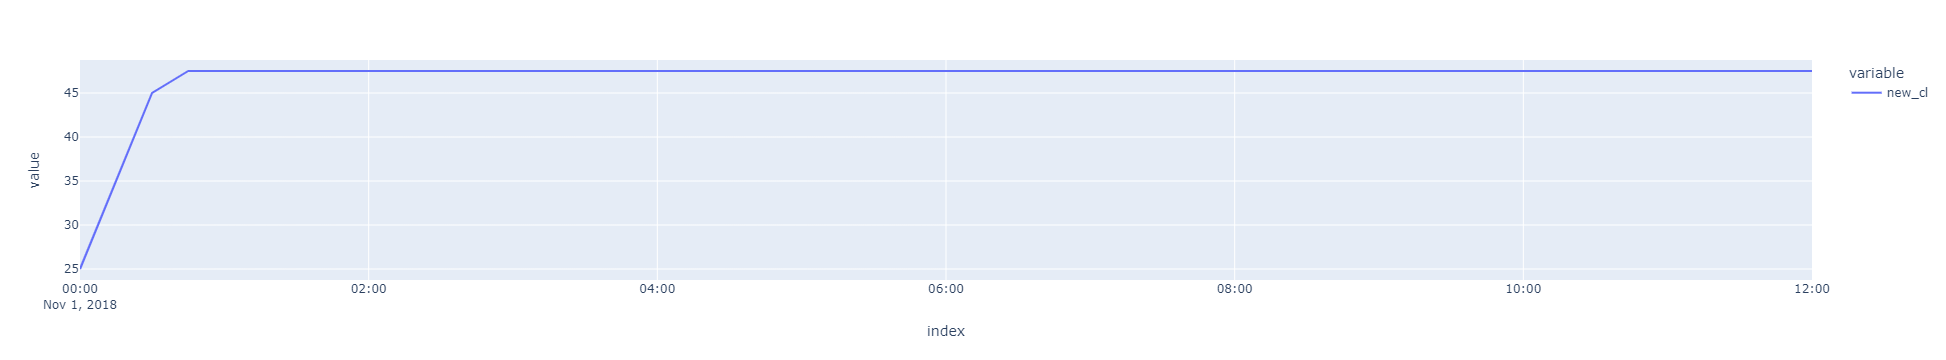

In [46]:
import plotly.express as px

fig = px.line(df['new_cl'])
fig.show()

In [47]:
df.index = df.index.tz_localize('Europe/Amsterdam')

In [48]:
for col in price_data.columns:
    df[col] = price_data[col]

df['nomination_MWh'] = df['DAM'] * df['MW (VDG)']
df['heatpump_cons_MWh'] = 9
df['imbalance_MWh'] = df['nomination_MWh'] - df['heatpump_cons_MWh']
df['day-ahead costs'] = df['nomination_MWh'] * df['DAM'] 

is_pos = df['imbalance_MWh'] > 0
df.loc[is_pos, 'imbalance costs'] = -df.loc[is_pos, 'imbalance_MWh'] * df['POS'] 

is_neg = df['imbalance_MWh'] < 0
df.loc[is_neg, 'imbalance costs'] = -df.loc[is_neg, 'imbalance_MWh'] * df['NEG'] 

df['total cost'] = df['day-ahead costs'] + df['imbalance costs']

In [49]:
df[:10]

Tsource (VDG)  Tsink (VDG)   MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109   0.000000   
2018-11-01 00:15:00+01:00      54.578777   138.960493   0.000000   
2018-11-01 00:30:00+01:00      65.166672   139.885329   0.000000   
2018-11-01 00:45:00+01:00      65.358078   139.731901   0.000000   
2018-11-01 01:00:00+01:00      64.947536   139.577871   0.000000   
2018-11-01 01:15:00+01:00      65.073433   139.423357   0.000000   
2018-11-01 01:30:00+01:00      47.711559   140.328730   0.000000   
2018-11-01 01:45:00+01:00      29.525829   140.298902   0.000000   
2018-11-01 02:00:00+01:00      65.715569   139.991650  10.139587   
2018-11-01 02:15:00+01:00      65.929909   148.342325  19.585104   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    hp_mass  \
2018-11-01 00:00:00+01:00      19.897433   147.731814  0.000000  52.101451   
2018-11-01 00:15:00+01:00      17.950905   148.138964  0.000000  53.242241   
2018-11-01 00:30:00+01:00      33.500757   147.585426  0.000000  52.890236   
2018-11-01 00:45:00+01:00      42.203876   147.547612  0.000000  52.948310   
2018-11-01 01:00:00+01:00      18.702675   148.260335  0.000000  53.006741   
2018-11-01 01:15:00+01:00      19.903652   149.186865  0.000000  53.065485   
2018-11-01 01:30:00+01:00      19.574467   147.800016  0.000000  52.723117   
2018-11-01 01:45:00+01:00      17.065464   147.906886  0.000000  52.734326   
2018-11-01 02:00:00+01:00      49.339708   149.603741  3.333301  52.850067   
2018-11-01 02:15:00+01:00      61.721718   155.887905  6.455359  49.874963   

                           process_mass                   COP  charge_mass  \
2018-11-01 00:00:00+01:00     42.017299   (5.386969459992516)    10.084152   
2018-11-01 00:15:00+01:00     42.937291   (4.882106135030027)    10.304950   
2018-11-01 00:30:00+01:00     42.653416  (5.5258665771869335)    10.236820   
2018-11-01 00:45:00+01:00     42.700250   (5.549424302045392)    10.248060   
2018-11-01 01:00:00+01:00     42.747372   (5.528286493353138)    10.259369   
2018-11-01 01:15:00+01:00     42.794746   (5.547058190973266)    10.270739   
2018-11-01 01:30:00+01:00     42.518642   (4.462765657815752)    10.204474   
2018-11-01 01:45:00+01:00     42.527682   (3.731041234226957)    10.206644   
2018-11-01 02:00:00+01:00     42.621021   (5.560223997670469)    10.229045   
2018-11-01 02:15:00+01:00     40.221745   (5.112607341877656)     9.653219   

                           ...    POS    NEG  ForeNeg  ForePos nomination_MWh  \
2018-11-01 00:00:00+01:00  ...  46.39  46.39    80.19    48.13       0.000000   
2018-11-01 00:15:00+01:00  ...  43.08  43.08    83.91    83.82       0.000000   
2018-11-01 00:30:00+01:00  ...  43.13  43.13    60.04    70.77       0.000000   
2018-11-01 00:45:00+01:00  ...  46.29  46.29    56.14    54.47       0.000000   
2018-11-01 01:00:00+01:00  ...  32.03  32.03    51.11    43.04       0.000000   
2018-11-01 01:15:00+01:00  ...  32.03  32.03    36.80    32.58       0.000000   
2018-11-01 01:30:00+01:00  ...  34.48  34.48    47.60    41.91       0.000000   
2018-11-01 01:45:00+01:00  ...  32.07  32.07    35.57    29.42       0.000000   
2018-11-01 02:00:00+01:00  ...  40.66  40.66    37.61    34.40     446.141846   
2018-11-01 02:15:00+01:00  ...  46.04  46.04    32.69    34.20     861.744591   

                           heatpump_cons_MWh  imbalance_MWh  day-ahead costs  \
2018-11-01 00:00:00+01:00                  9      -9.000000         0.000000   
2018-11-01 00:15:00+01:00                  9      -9.000000         0.000000   
2018-11-01 00:30:00+01:00                  9      -9.000000         0.000000   
2018-11-01 00:45:00+01:00                  9      -9.000000         0.000000   
2018-11-01 01:00:00+01:00                  9      -9.000000         0.000000   
2018-11-01 01:15:00+01:00                  9      -9.000000         0.000000   
2018-11-01 01:30:00+01:00                  9      -9.000000         0.000000   
2018-11-01 01:45:00+01:00   